## Setup

In [59]:
import os, getpass
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")

In [60]:
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
# llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0)
# llm = ChatOpenAI(model="gpt-4o", temperature=0.5)

In [61]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "kaggle_agent"

In [62]:
import importlib

importlib.reload(importlib.import_module("prompts.base_prompt"))
from prompts.base_prompt import (
    base_prompt,
    planner_prompt,
    replanner_prompt,
    developer_prompt,
    summarizer_prompt,
    reader_prompt,
)

In [63]:
importlib.reload(importlib.import_module("prompts.phase_prompts"))
from prompts.phase_prompts import eda_prompt

phase_prompts = {
    "data exploration and analysis": eda_prompt,
}

## 1. Problem understanding graph

In [64]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [65]:
class ProblemStatementState(TypedDict):
    problem_statement: str  # = Field(description="Overview of the problem statement")
    dataset_description: str  # = Field(description="Description of the dataset")

    feedback: str  # = Field(None, description="Feedback from the human on the summary")
    summary: str  # = Field(None, description="Summary of the problem statement")


class Summary(BaseModel):
    summary: str = Field(description="Summary of the problem statement")

In [66]:
def create_summary(state: ProblemStatementState):
    print("Creating summary")
    problem_statement = state["problem_statement"]
    dataset_description = state["dataset_description"]

    feedback = state.get("feedback", "")
    prompt = reader_prompt.format(
        problem_statement=problem_statement,
        dataset_description=dataset_description,
        feedback=feedback,
    )

    summary = llm.with_structured_output(Summary).invoke(
        [SystemMessage(content=prompt)]
        + [HumanMessage(content="Generate the summary.")]
    )

    return {"summary": summary.summary}


def human_feedback(state: ProblemStatementState):
    """No-op node that should be interrupted on"""
    pass


def should_continue(state: ProblemStatementState):
    """Return the next node to execute"""

    # Check if human feedback
    human_analyst_feedback = state.get("human_feedback", None)
    if human_analyst_feedback:
        return "create_summary"

    # Otherwise end
    return END

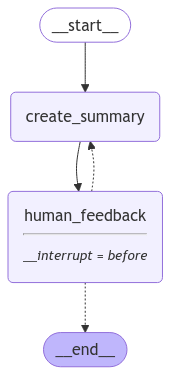

In [67]:
# Add nodes and edges
builder = StateGraph(ProblemStatementState)
builder.add_node("create_summary", create_summary)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_summary")
builder.add_edge("create_summary", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_summary", END]
)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [68]:
# read the problem statement (file: problem_statement.md)
problem_statement = open("resources/overview.md").read()

# read the dataset description (file: dataset_description.md)
dataset_description = open("resources/dataset.md").read()

In [69]:
from IPython.display import Markdown, display_markdown

# Run the graph until the first interruption
thread = {"configurable": {"thread_id": "1"}}

def run():
    for event in graph.stream(
        {
            "problem_statement": problem_statement,
            "dataset_description": dataset_description,
        },
        thread,
        stream_mode="values",
    ):
        summary_str = event.get("summary", None)
        if summary_str:
            display_markdown(Markdown(summary_str))
    
run()

Creating summary


The problem statement involves predicting a Starcraft player based on their behavioral traces. The necessary files are train.csv and test.csv, which contain labeled and unlabeled behavioral traces, respectively. The data format consists of comma-separated values, including a unique player ID, the player's race, and various actions such as selections and hotkeys, all timestamped with time windows in seconds. The prediction target is to identify the player, and the submission format requires a RowId and the corresponding prediction. The evaluation metric is the Mean F1-Score, which balances precision and recall. Key acronyms include F1, tp, fp, fn, and ID.

In [70]:
summary_str = graph.get_state(thread).values["summary"]
summary_str

"The problem statement involves predicting a Starcraft player based on their behavioral traces. The necessary files are train.csv and test.csv, which contain labeled and unlabeled behavioral traces, respectively. The data format consists of comma-separated values, including a unique player ID, the player's race, and various actions such as selections and hotkeys, all timestamped with time windows in seconds. The prediction target is to identify the player, and the submission format requires a RowId and the corresponding prediction. The evaluation metric is the Mean F1-Score, which balances precision and recall. Key acronyms include F1, tp, fp, fn, and ID."

In [71]:
# Get state and look at next node
# state = graph.get_state(thread)
# state.next

In [72]:

# We now update the state as if we are the human_feedback node
# graph.update_state(
#     thread,
#     {
#         "feedback": "Explain in more detail the what the columns of the training data represent. Also add clearly the path of the files needed"
#     },
#     as_node="human_feedback",
# )

In [73]:
# run()

In [74]:
# We now update the state as if we are the human_feedback node
# graph.update_state(thread, {"feedback": None}, as_node="human_feedback")

In [75]:
# final_state = graph.get_state(thread)
# final_state.next

## 2.0 Thinker/Coder graph

In [76]:
class Code(BaseModel):
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


code_gen_llm = llm.with_structured_output(Code)

In [77]:
from typing import List
from typing_extensions import TypedDict


class DeveloperState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        code_output : Code output
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    code_output: str
    iterations: int

In [78]:
import io
from contextlib import redirect_stdout

# Max tries
max_iterations = 3

# Reflect
flag = "reflect"


### Nodes
def generate(state: DeveloperState):
    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_llm.invoke(messages)
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: DeveloperState):
    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    f = io.StringIO()
    try:
        with redirect_stdout(f):
            exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }
    output = f.getvalue()
    messages += output
    print("---CODE EXECUTION OUTPUT:---")
    print(output)

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "code_output": output,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: DeveloperState):
    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]
    code_output = state.get("code_output", "")

    # Reflection
    reflections = code_gen_llm.invoke(messages)
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {
        "generation": code_solution,
        "code_output": code_output,
        "messages": messages,
        "iterations": iterations,
    }


### Edges
def decide_to_finish(state: DeveloperState):
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "reflect"

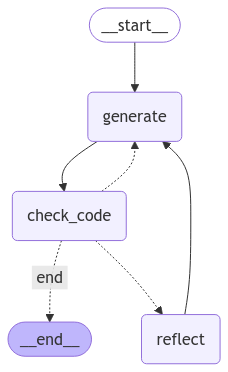

In [79]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(DeveloperState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
developer = workflow.compile()

display(Image(developer.get_graph(xray=True).draw_mermaid_png()))

In [80]:
# Test
# question = "Load the CSV file named sample.csv in pandas and compute the correlations between columns 'Age' and 'Wealth'"
# solution = developper.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

## 2.1 Replan graph

In [81]:
from typing import Tuple, Annotated, Union
import operator
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent

In [82]:
class PlanExecute(TypedDict):
    context: str
    phase: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    summary: str


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


planner = llm.with_structured_output(Plan)

In [83]:
class Response(BaseModel):
    """Summary to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Summary, Plan] = Field(
        description="Action to perform. If you want to stop, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner = llm.with_structured_output(Act)

In [84]:
class Summary(BaseModel):
    summary: str = Field(description="Summary of the problem statement")


summarizer = llm.with_structured_output(Summary)

In [85]:
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]

    task_formatted = developer_prompt.format(
        context=state["context"],
        phase=state["phase"],
        summary=state["summary"],
        plan=plan_str,
        step=task,
    )

    agent_response = developer.invoke(
        {"iterations": 0, "error": "", "messages": [("user", task_formatted)]}
    )

    summary_prompt = f"""
    ## Task ##
    {task}
    
    ## Python code ##
    {agent_response["generation"]}
    
    ## Code output ##
    {agent_response["code_output"]}
    
    ## Your task ##
    Above are:
    - a task related to a data science problem
    - the python code for that task
    - the output of the code
    
    Please summarize the code output.
    """
    task_output_summary = (
        llm.with_structured_output(Summary)
        .invoke([SystemMessage(content=summary_prompt)])
        .summary
    )

    task_output = f"""Python code:    
    {agent_response["generation"]}
    
    Output summary:
    {task_output_summary}
    """
    return {
        "past_steps": state["past_steps"] + [(task, task_output)],
    }


def plan_step(state: PlanExecute):
    prompt = planner_prompt.format(
        context=state["context"],
        phase=state["phase"],
        summary=state["summary"],
        information=phase_prompts[state["phase"]],
    )
    plan = planner.invoke([SystemMessage(content=prompt)])
    return {"plan": plan.steps}


def replan_step(state: PlanExecute):
    prompt = replanner_prompt.format(
        context=state["context"],
        phase=state["phase"],
        summary=state["summary"],
        information=phase_prompts[state["phase"]],
        plan=state["plan"],
        past_steps=state["past_steps"],
    )
    output = replanner.invoke([SystemMessage(content=prompt)])
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def summarize_step(state: PlanExecute):
    steps = state["past_steps"]
    steps_str = "\n".join(f"{i+1}. {step}" for i, (step, _) in enumerate(steps))

    formatted_prompt = summarizer_prompt.format(
        context=state["context"],
        phase=state["phase"],
        summary=state["summary"],
        steps_str=steps_str,
    )

    return {"summary": llm.invoke([SystemMessage(content=formatted_prompt)])}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "summarizer"
    else:
        return "developer"

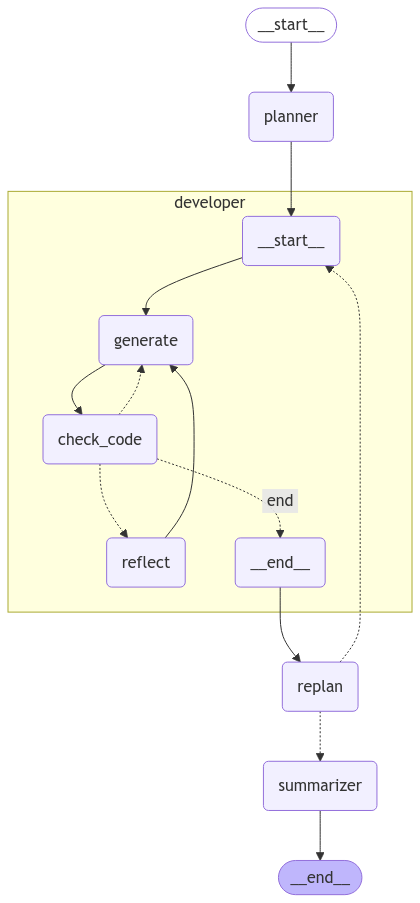

In [86]:
workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("developer", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

# Add a summary node
workflow.add_node("summarizer", summarize_step)

workflow.add_edge(START, "planner")

# From plan we go to developer
workflow.add_edge("planner", "developer")

# From developer, we replan
workflow.add_edge("developer", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["developer", "summarizer"],
)

workflow.add_edge("summarizer", END)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 3. Data Exploration

In [ ]:
config = {"recursion_limit": 100}

input = PlanExecute(
    context=summary_str,
    phase="data exploration and analysis",
    summary="",
)

for event in app.stream(input, config=config):
    print(event)

## 4. Feature Engineering

## 5. Model Building

## 6. Model Evaluation 

## 7. Submission 